In [1]:
# Directories
import os
os.chdir(r"E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis")
print(os.getcwd())

E:\academy\OneDrive - IIT Delhi\3. IIT DELHI\2. Academics\1_PAPER\2_Analysis


In [2]:
#Array packages
import cartopy.crs as ccrs
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc4

from scipy.stats import kendalltau
import pymannkendall as mk

#plots
import matplotlib.pyplot as plt
import rioxarray as rio
import geopandas as gpd
from shapely.geometry import mapping
import matplotlib.ticker as ticker

import rasterio.mask
#Progress meter
from dask.diagnostics import ProgressBar
from tqdm import tqdm

# Directories
import os
import glob
import dask
#import h5netcdf
import scipy
import tqdm


C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 1 Regridding

In [3]:
mdl=4
model=["LIS_MERRA2","LIS_IMD","LIS_CHIRPS","LIS_ERA5","LIS_IMDcalib"]

lsm=xr.open_mfdataset(f"DATA_p/{model[1]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})

lsm_calib = xr.open_mfdataset(f"DATA_p/{model[4]}_1980_2021.nc",engine='netcdf4', parallel=True,chunks={'time': 'auto'})
lsm_calib = lsm_calib.interp(lat=lsm.lat,lon=lsm.lon,method='linear')

#lsm_calib.to_netcdf('DATA_p/LIS_IMDc_1980_2021.nc') 

C:\Users\sstar\anaconda3\envs\imed\Lib\site-packages\xarray\core\indexing.py:1436: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


## 2 Clipping only indus from lsm to lsm_calib

In [4]:

## Regional preprocessing
gdf_p=gpd.read_file('DATA_p/shapefile/south_asia_p.shp')

B=gdf_p[gdf_p['Basin'] == gdf_p['Basin'][0]]
lsm.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
lsm.rio.write_crs("EPSG:4326", inplace=True)
lsm_clip = lsm.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)

B=gdf_p[gdf_p['Basin'] == gdf_p['Basin'][0]]
lsm_calib.rio.set_spatial_dims(y_dim="lat",x_dim="lon", inplace=True)
lsm_calib.rio.write_crs("EPSG:4326", inplace=True)
lsm_c_clip = lsm_calib.rio.clip(B.geometry.apply(mapping), B.crs, drop=True)



In [5]:
var=['TotalPrecip_tavg','Evap_tavg','Qs_tavg','Evap_tavg','SoilMoist_tavg','Qsb_tavg']

In [6]:
lsm_clip=lsm_clip.interp(lat=lsm_c_clip.lat,lon=lsm_c_clip.lon,method='linear')
lsm_calib=lsm_calib[var].compute()
lsm_clip=lsm_clip[var].compute()
lsm_c_clip=lsm_c_clip[var].compute()

lsm_calib['SoilMoist_tavg']=lsm_calib['SoilMoist_tavg'].mean(dim='SoilMoist_profiles')
lsm_clip['SoilMoist_tavg']=lsm_clip['SoilMoist_tavg'].mean(dim='SoilMoist_profiles')
lsm_c_clip['SoilMoist_tavg']=lsm_c_clip['SoilMoist_tavg'].mean(dim='SoilMoist_profiles')


##### METHOD 1

9953it [1:47:01,  1.55it/s] 


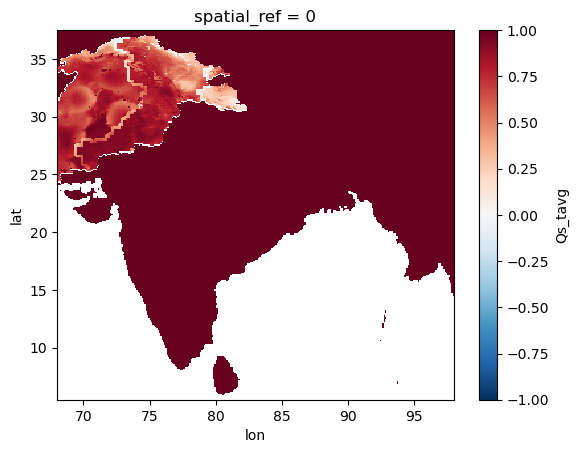

In [7]:
from tqdm import tqdm

#Method 1
lsm_calib1=lsm_calib.to_dataframe()
lsm_clip1=lsm_clip.to_dataframe()

lon1=lsm_c_clip.lon.values
lat1=lsm_c_clip.lat.values
ind=np.where(~np.isnan(lsm_c_clip['Qs_tavg'].mean(dim='time').values)) ## Outside nan should be removed
lat_index, lon_index = ind[0], ind[1]

lat_index=lat1[lat_index]
lon_index=lon1[lon_index]

for la,lo in tqdm(zip(lat_index,lon_index)):
    lsm_calib1.loc[(slice(None),la,lo),:]=lsm_clip1.loc[(slice(None),la,lo),:].values

A_new=lsm_calib1.to_xarray()
A_new.to_netcdf('DATA_p/LIS_IMDcnew_1980_2021.nc') 

#success
xr.corr(A_new['Qs_tavg'],lsm_calib['Qs_tavg'],dim='time').plot()


#### Method2 : without converting into dataframe

In [10]:
lsm_calib = lsm_calib.drop_vars('SoilMoist_inst') # becausee lsm_clip doesnt havee inst_SoilMoist


lon1=lsm_c_clip.lon.values
lat1=lsm_c_clip.lat.values
ind=np.where(~np.isnan(lsm_c_clip['Qs_tavg'].mean(dim='time').values)) ## Outside nan should be removed
lat_index, lon_index = ind[0], ind[1]

lat_index=lat1[lat_index]
lon_index=lon1[lon_index]

for i,j in zip(lat_index,lon_index):
    lsm_calib = lsm_calib.where(~((lsm_calib.lat==i) & (lsm_calib.lon==j)), lsm_clip.sel(lat=i, lon=j,method='nearest'))
    
lsm_calib.to_netcdf('DATA_p/LIS_IMDcnew1_1980_2021.nc')     

RecursionError: maximum recursion depth exceeded while calling a Python object


KeyboardInterrupt



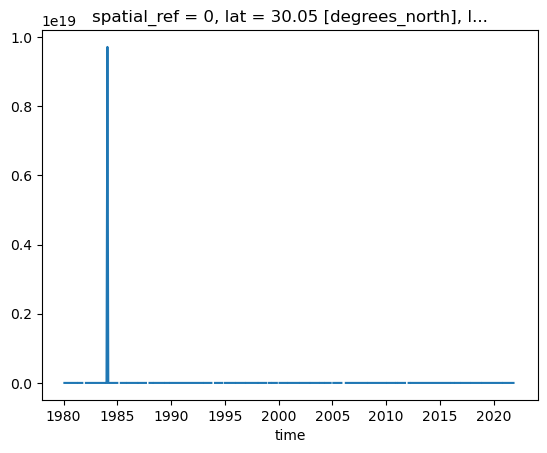

In [41]:
RE=lsm_clip['Qs_tavg'].sel(lon=75,lat=30,method='nearest').compute()/lsm_clip['TotalPrecip_tavg'].sel(lon=75,lat=30,method='nearest').compute()
RE.plot()

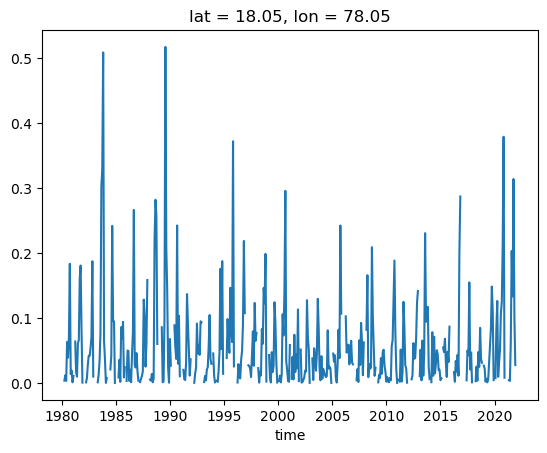

In [61]:
#RE=lsm_calib['Qs_tavg'].sel(lon=78,lat=15,method='nearest').compute()/lsm_calib['TotalPrecip_tavg'].sel(lon=78,lat=15,method='nearest').compute()
#RE.plot()

RE=A_new['Qs_tavg'].sel(lon=78,lat=18,method='nearest').compute()/A_new['TotalPrecip_tavg'].sel(lon=78,lat=18,method='nearest').compute()
RE.plot()

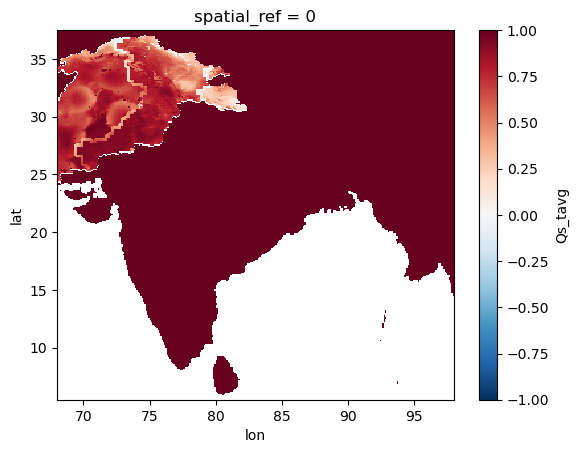